In [1790]:
from datetime import datetime
from tkinter import filedialog
from tkinter import messagebox
from tkinter import filedialog
import tkinter as tk
import os
import pandas as pd
from matplotlib import pyplot as plt
from tkinter.filedialog import askopenfilename
from sklearn.preprocessing import MinMaxScaler
import timeit
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed, Bidirectional, Input
from sympy.physics.units import acceleration


In [1791]:
def ui_load_ixxt_archive(file_path):
    # Se o caminho não for fornecido, abrir a caixa de diálogo para selecionar o arquivo
    if not file_path:
        file_path = filedialog.askopenfilename(
            title="Selecione o arquivo CSV",
            filetypes=(("CSV files", "*.CSV"), ("all files", "*.*"))
        )
    
    # Verificar se o caminho foi fornecido ou selecionado
    if file_path:
        df = fileToDataframe(file_path)  # Simulação do carregamento de dados
        return df
    else:
        print("Nenhum arquivo foi selecionado.")
        return None

In [1792]:
def process_data(hex_data, type = 'df'):
    if type == 'row':

        if isinstance(hex_data, str):
            return hex_data.split(' ')
        return []

    elif type == 'df':
        # Verifica se a entrada é uma string
        if isinstance(hex_data, str):
            byte_list = hex_data.split(' ')

            # Verifica se a lista contém exatamente 8 itens
            if len(byte_list) < 8:
                byte_list.extend(['00'] * (8 - len(byte_list)))

            # Converte os valores de hexadecimal para decimal
            byte_list = [int(byte, 16) for byte in byte_list]

            # Converte a lista em um DataFrame com uma linha e 8 colunas
            df = pd.DataFrame([byte_list])

            return byte_list  # Retorna a lista para ser expandida em colunas
        else:
            raise ValueError("A entrada deve ser uma string hexadecimal.")


In [1793]:
def fileToDataframe(file_path):
    df = pd.read_csv(file_path, sep=';', quotechar='"', skiprows=6)
    df = df.dropna(subset=['Data (hex)'])
    df['Identifier (hex)'] = df['Identifier (hex)'].apply(lambda x: int(x, 16))

    byte_columns = df['Data (hex)'].apply(process_data)
    
    byte_columns = pd.DataFrame(byte_columns.tolist(), index=df.index, columns=[f'byte_{i + 1}' for i in range(8)])
    print(byte_columns)
    columns_to_drop = ['Format', 'Flags', 'Time', 'Data (hex)']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    df = pd.concat([df, byte_columns], axis=1)
    df = df.rename(columns={'Identifier (hex)': 'pgn'})
    return df


In [1794]:
def save_df_raw(df):
    if df is None:
        messagebox.showwarning("Aviso", "Carregue um arquivo primeiro.")
        return

    save_path = filedialog.asksaveasfilename(
        defaultextension=".csv",
        filetypes=(("CSV files", "*.csv"), ("All files", "*.*")),
        title="Salvar o DataFrame completo"
    )

    if save_path:
        df.to_csv(save_path, index=False)
        messagebox.showinfo("Sucesso", "DataFrame salvo com sucesso!")


In [1795]:
def decimacao_dinamica(df, coluna, tamanho):
    
    df[coluna] = df[coluna].apply(lambda x: list(map(int, x.split())) if isinstance(x, str) and x.strip() else [])

    def decimar_lista(lst, tamanho_fixo):
        if len(lst) == 0:
            print(f"Lista vazia, preenchendo com zeros até {tamanho_fixo} elementos.")
            return [0] * tamanho_fixo  # Se a lista estiver vazia, retorna uma lista de zeros
        elif len(lst) == tamanho_fixo:
            print(f"Lista já está no tamanho fixo ({tamanho_fixo}).")
            return lst  # Se já estiver no tamanho fixo, retorna a lista original
        elif len(lst) > tamanho_fixo:
            # Se a lista for maior, faz a decimação (subsample)
            step = len(lst) // tamanho_fixo  # Calcula o passo necessário
            decimated_lst = lst[::step][:tamanho_fixo]  # Fatiamento
            print(f"Lista maior que o tamanho fixo ({len(lst)} > {tamanho_fixo}). Aplicando decimação.")
            print(f"Lista decimada: {decimated_lst}")
            return decimated_lst
        else:
            # Se for menor, preenche com zeros até atingir o tamanho
            filled_lst = lst + [0] * (tamanho_fixo - len(lst))
            print(f"Lista menor que o tamanho fixo ({len(lst)} < {tamanho_fixo}). Preenchendo com zeros.")
            print(f"Lista preenchida: {filled_lst}")
            return filled_lst

    print(f"dataframe antes decimaçao:{df}")
    # Aplicar a decimação dinâmica na coluna
    df[coluna] = df[coluna].apply(lambda lst: decimar_lista(lst, tamanho))

    print("\nApós a decimação dinâmica:")
    print(df[coluna])

    return df

In [1796]:
def normalizar_dataframe(df_decimado):
    if df_decimado is None or df_decimado.empty:
        print("Aviso: O DataFrame está vazio ou não foi carregado.")
        return None
    
    try:
        
        scaler = MinMaxScaler(feature_range=(-1, 1))
        
        for i in range(len(df_decimado)):
            # Transformar a linha em um array 2D, pois o scaler espera isso
            data = np.array(df_decimado['x'].iloc[i]).reshape(-1, 1)
            
            # Aplicar o fit_transform para a linha atual
            data_normalized = scaler.fit_transform(data)
            
            # Substituir a linha normalizada no DataFrame
            df_decimado['x'].iloc[i] = data_normalized.flatten().tolist()

        return df_decimado
    except Exception as e:
        print(f"Erro ao normalizar o DataFrame: {str(e)}")
        return None


In [1797]:
def filtrar_dataframe(df, filtro_pgn, filtro_byte):

    if df is None:
        messagebox.showwarning("Aviso", "Carregue um arquivo primeiro.")
        return None

    if filtro_pgn and filtro_byte:
        try:
            filtered_df = df[df['pgn'] == int(filtro_pgn, 16)]  # Se pgn for uma string hexadecimal

            # Verificar se o byte filtrado existe
            if filtro_byte in filtered_df.columns:
                # Filtrar os valores do byte especificado que não são 'FF' (255 em decimal)
                filtered_df = filtered_df[[filtro_byte]]
                #filtered_df = filtered_df[filtered_df[filtro_byte] != 255]
                filtered_df = filtered_df.rename(columns={filtro_byte: 'x'})


                if not filtered_df.empty:
                    #normalized_df = normalizar_dataframe(filtered_df)
                    #return normalized_df
                    return filtered_df
                else:
                    messagebox.showinfo("Informação", "Nenhum valor diferente de FF encontrado após filtrar.")
                    return None
            else:
                messagebox.showinfo("Informação", f"A coluna {filtro_byte} não existe.")
                return None
        except Exception as e:
            messagebox.showerror("Erro", f"Erro ao aplicar filtros: {str(e)}")
            return None
    else:
        messagebox.showwarning("Aviso", "Preencha os campos de filtro antes de filtrar.")
        return None

In [1798]:
def vizData(df):
    if df is None:
        messagebox.showwarning("Aviso", "Carregue um arquivo primeiro.")
        return

    # Visualização da coluna específica
    plt.figure(figsize=(20, 10), dpi=100)
    plt.plot(range(len(df)), df['x'], linestyle='-', color='b',
                linewidth=0.7, label='x')
    plt.xlabel('X')
    plt.ylabel('Value')
    plt.title(f"Visualização de Dados - PGN: {filtro_pgn}, Byte: {filtro_byte}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [1799]:
def save_df_train(train_df):
    if train_df is None:
        messagebox.showwarning("Aviso", "Carregue um arquivo primeiro.")
        return

    save_path = filedialog.asksaveasfilename(
        defaultextension=".csv",
        filetypes=(("CSV files", "*.csv"), ("All files", "*.*")),
        title="Salvar o DataFrame de treino completo"
    )

    if save_path:
        train_df.to_csv(save_path, index=False)
        messagebox.showinfo("Sucesso", "DataFrame de treino salvo com sucesso!")

In [1800]:
def rotular_df(df, label):

    label_dict = {
        "Onda Quadrada": 1,
        "Onda Seno": 2,
        "Onda Triangular": 3
    }

    # Verifica se o rótulo textual existe no dicionário
    if label not in label_dict:
        raise ValueError(f"Rótulo '{label}' não é válido. Use 'Onda Quadrada', 'Onda Seno' ou 'Onda Triangular'.")
    
    numeric_label = label_dict[label]

    if df is None:
        raise ValueError("O dataframe está vazio, carrega 'treino'")
    else:
        # Preencher o DataFrame com o valor numérico correspondente
        rotuled_df = df.copy()
        rotuled_df['label'] = numeric_label

    return rotuled_df


In [1801]:
def concatenate_dataframes(df_list):
    rows = []
    
    # Iterar sobre cada DataFrame na lista
    for df in df_list:
        # Concatenar os valores da coluna 'X' em uma única célula
        concatenated_X = ' '.join(map(str, df['x'].tolist()))
        # Adicionar à lista de resultados como um dicionário
        rows.append({'x': concatenated_X})
    
    # Converter a lista de dicionários para um DataFrame
    concatenated_df = pd.DataFrame(rows)
    
    return concatenated_df

In [1802]:
def plot_line_for_each_row(df):
    if 'x' not in df.columns:
        raise ValueError("O DataFrame deve conter uma coluna 'x'")
    
    # Iterar sobre cada linha do DataFrame
    for index, row in df.iterrows():
        # Como a coluna 'x' já contém listas de valores, podemos usá-las diretamente
        values = row['x']  # Já é uma lista de floats ou inteiros
        
        plt.plot(values, label=f"Sinal {index + 1}")
    
    # Adicionar rótulos e título ao gráfico
    plt.xlabel("Índice")
    plt.ylabel("Valor")
    plt.title("Gráfico de Linhas para Cada Linha do DataFrame")
    plt.legend()
    plt.show()

In [1803]:
#velocidade
df_raw = ui_load_ixxt_archive("/home/allan/Documentos/Repostórios/pythonProject/JUMPY 2024/velocidade_0_20_5x_jumpy.CSV")  #26s #29,5 #30,7 #42,6

       byte_1  byte_2  byte_3  byte_4  byte_5  byte_6  byte_7  byte_8
0          24      72      48       0      76      50      48      48
1          48      48       0      97     187     164      32       0
2          50       0     240       0       0       0       0       0
3          24       0       0       1       0      82       0       0
4         255     153       0       7     173       0      32       0
...       ...     ...     ...     ...     ...     ...     ...     ...
69062       0       0      13     156     175     198      70       0
69063       0       0       0       3       0       0       0       0
69064       0       0       0       0       0       0       0       0
69065      32       9      64       2     208       7       0       0
69066       0      80       0       7      19       0      32       0

[69045 rows x 8 columns]


In [1804]:
filtro_byte = 3
filtro_pgn = '32d'
filtro_byte = f'byte_{filtro_byte}'
print(f"{filtro_byte} e {filtro_pgn}")

byte_3 e 32d


In [1805]:
filtered_df_one = filtrar_dataframe(df_raw, filtro_pgn, filtro_byte)
filtered_df_one.head()
filtered_df_one.shape

(2907, 1)

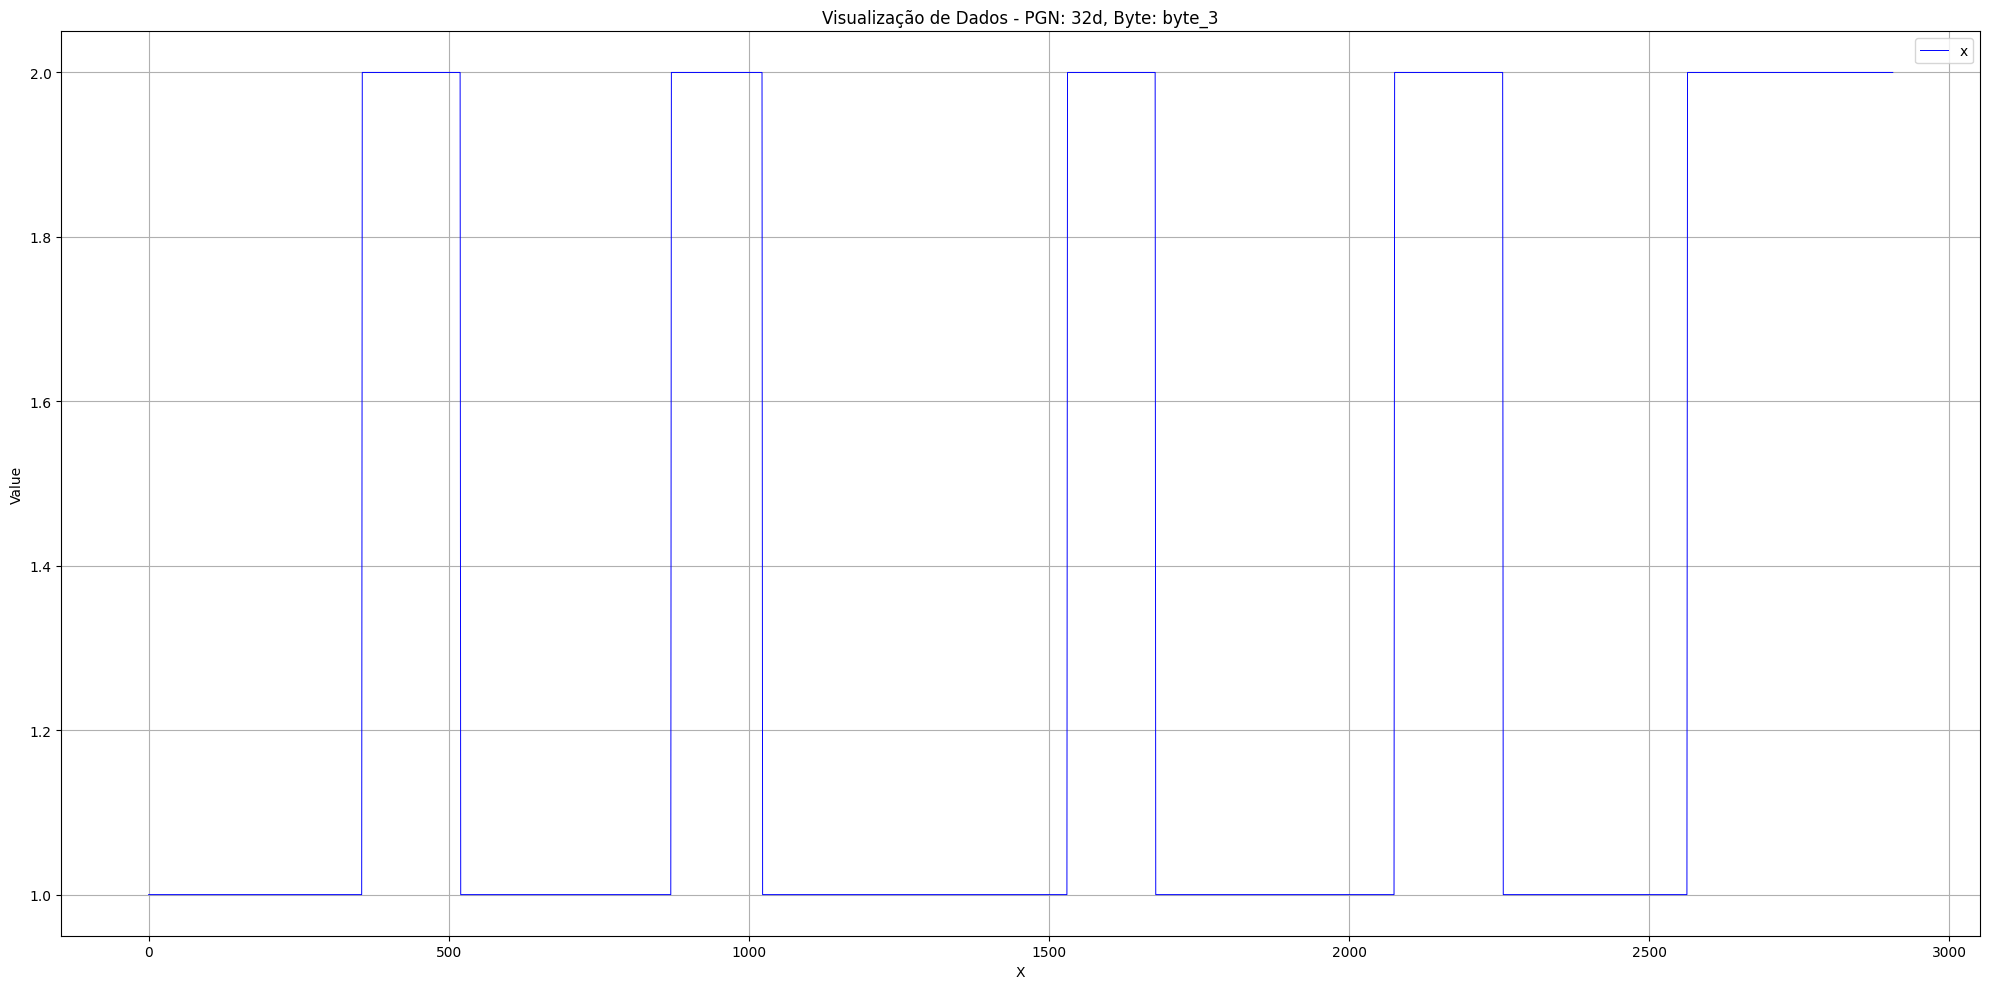

In [1806]:
vizData(filtered_df_one)

In [1807]:
#freio
df_raw = ui_load_ixxt_archive("/home/allan/Documentos/Repostórios/pythonProject/JUMPY 2024/pedal_freio_5x_jumpy.CSV")  #26s #29,5 #30,7 #42,6

       byte_1  byte_2  byte_3  byte_4  byte_5  byte_6  byte_7  byte_8
0         255     253       0       0      11      34      96     185
1         127     192       1       0     128       0       0       0
2           0       0      50       0      12      50      50      50
3          50       0       0      55       0       4       0       0
4         255     196       0       7      75       0      32       0
...       ...     ...     ...     ...     ...     ...     ...     ...
13182       0       0      50       0      12      50      50      50
13183      50       0       0      55       0       4       0       0
13184       0      50      41      50     193       1      68       0
13185     255     196       0       7      75       0      32       0
13186       8       0       0       0       0       0       0       0

[13187 rows x 8 columns]


In [1808]:
filtro_byte = 5
filtro_pgn = '208'
filtro_byte = f'byte_{filtro_byte}'
print(f"{filtro_byte} e {filtro_pgn}")

byte_5 e 208


In [1809]:
filtered_df_two = filtrar_dataframe(df_raw, filtro_pgn, filtro_byte)
filtered_df_two.head()
print(filtered_df_two.shape)

(1105, 1)


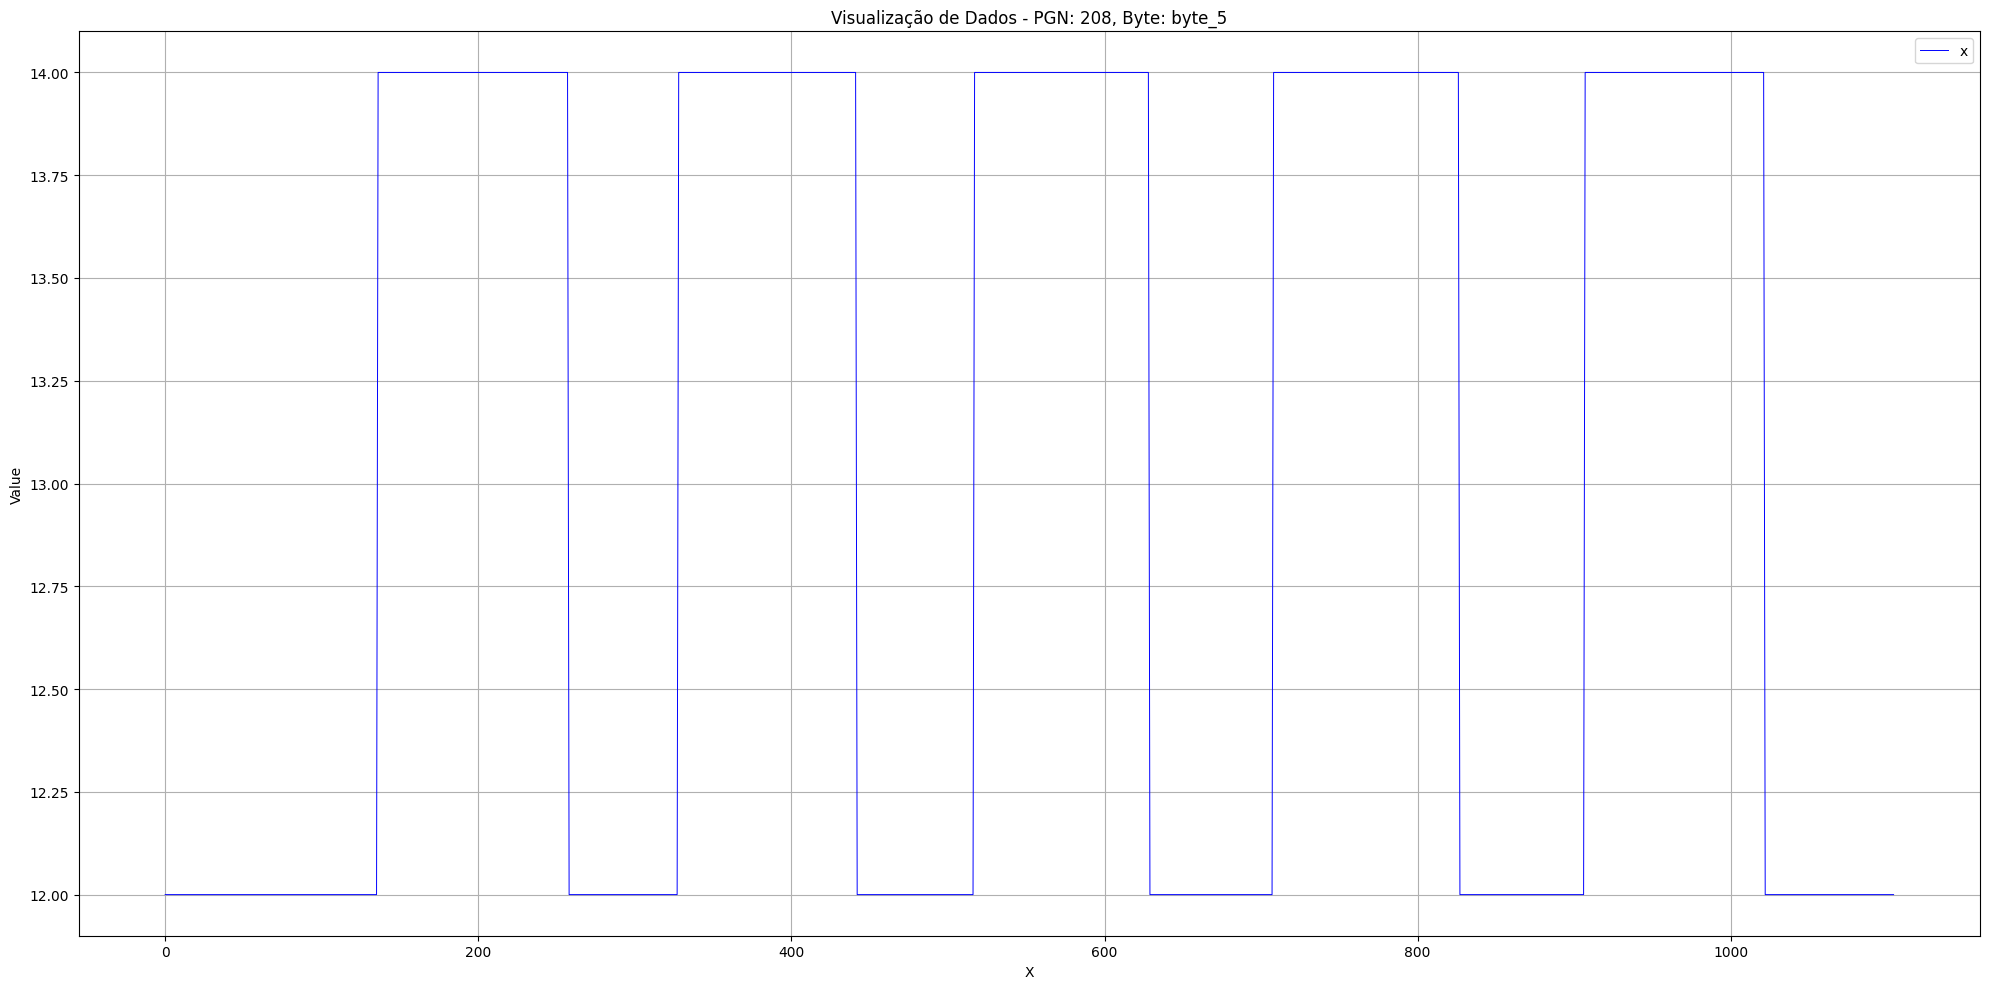

In [1810]:
vizData(filtered_df_two)

In [1811]:
#Limpador
df_raw = ui_load_ixxt_archive('/home/allan/Documentos/Repostórios/pythonProject/JUMPY 2024/limpador_vel1_5x_jumpy.CSV')  #26s #29,5 #30,7 #42,6

       byte_1  byte_2  byte_3  byte_4  byte_5  byte_6  byte_7  byte_8
0          93       0       0       0       0       0       0       0
1           0       0       0       0     175     215      70       0
2           0       0       0       0       0       0       0       0
3         255     195       0       7     196       0      32       0
4          25     168      49       0      76      50      49      49
...       ...     ...     ...     ...     ...     ...     ...     ...
16069     127     192       1       0     128       0       0       0
16070      25     128      47       0      76      50      47      47
16071      47      48       0     138       0     161      32       0
16072      50       0     240       0       0       0       0       0
16073     255     195       0       7     110       0      32       0

[16074 rows x 8 columns]


In [1812]:
filtro_byte = 2
filtro_pgn = '348'
filtro_byte = f'byte_{filtro_byte}'
print(f"{filtro_byte} e {filtro_pgn}")

byte_2 e 348


In [1813]:
filtered_df_three = filtrar_dataframe(df_raw, filtro_pgn, filtro_byte)
filtered_df_three.head()

,x
17,37
36,37
63,37
83,37
108,37


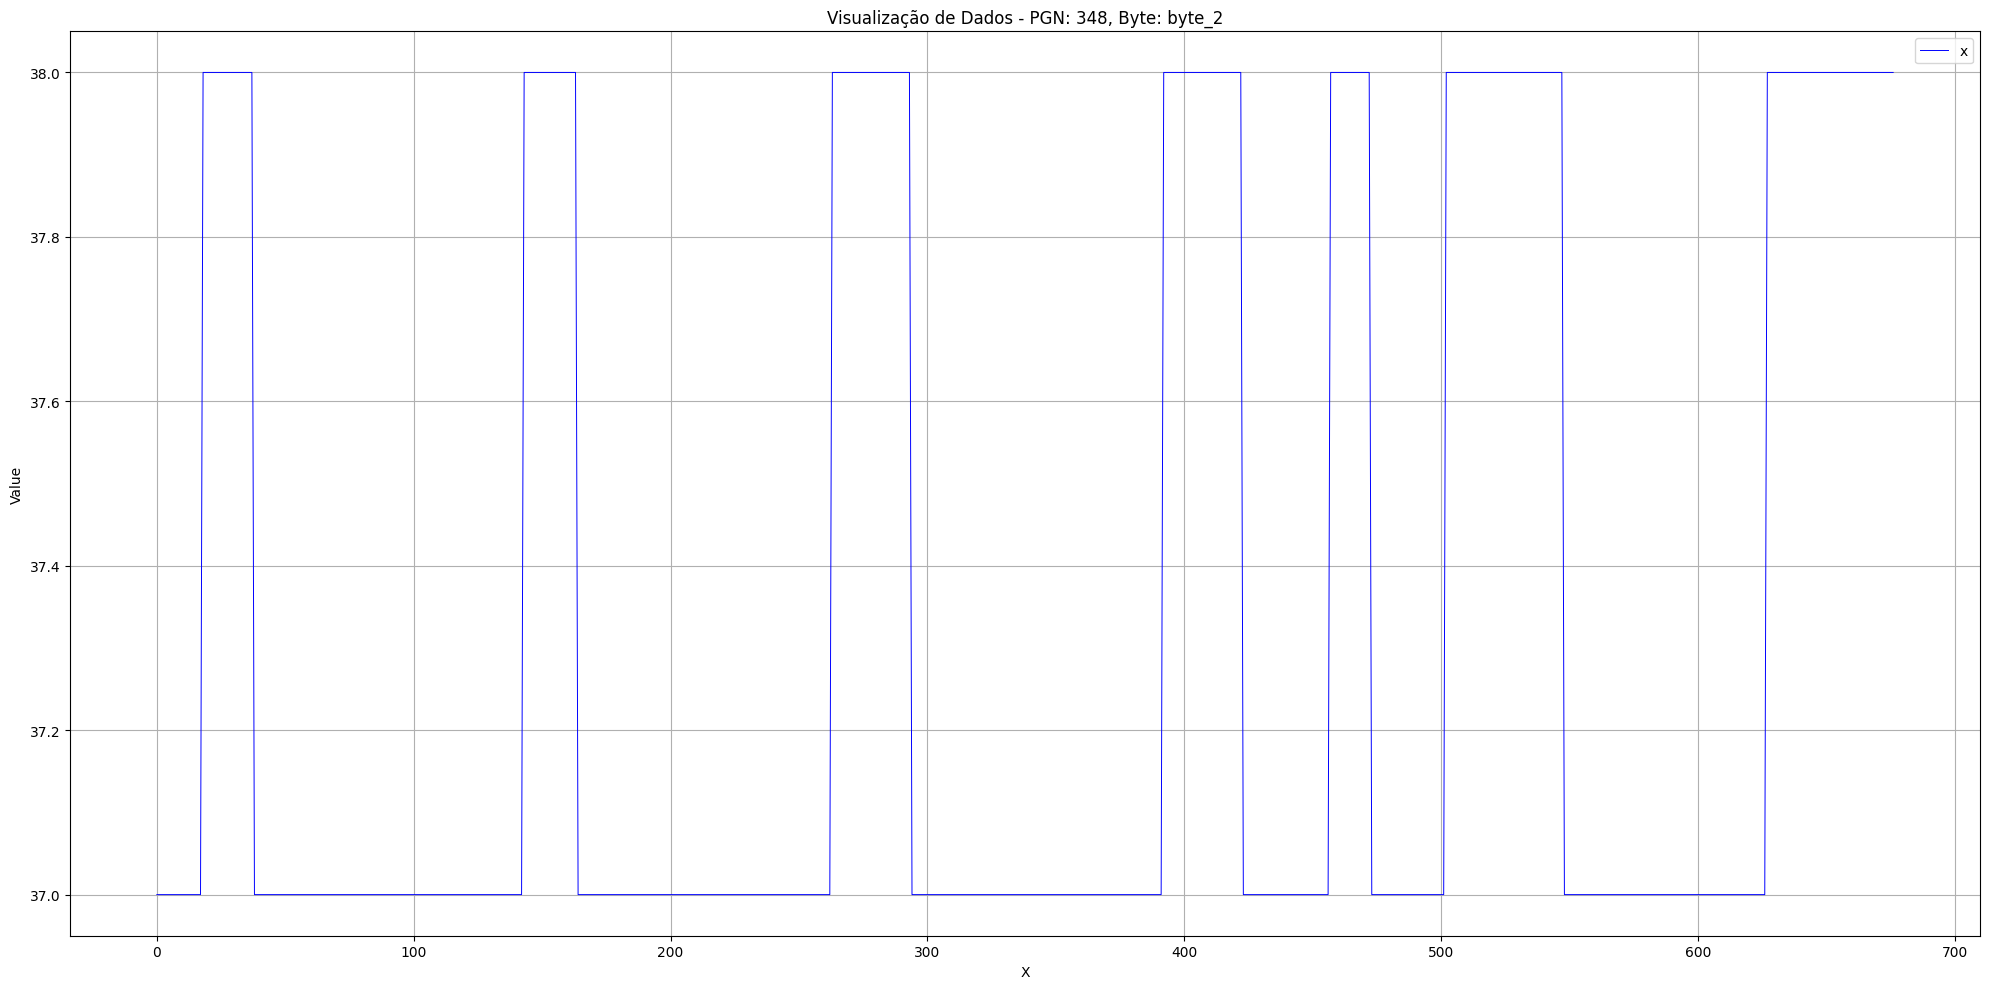

In [1814]:
vizData(filtered_df_three)

In [1815]:
df_list = [filtered_df_one, filtered_df_two, filtered_df_three]
df_concatenate = concatenate_dataframes(df_list)

In [1816]:
df_decimado = decimacao_dinamica(df_concatenate, 'x', 600)
    
normalized_df = normalizar_dataframe(df_decimado)
    
print(normalized_df)

dataframe antes decimaçao:                                                   x
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
1  [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1...
2  [37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 3...
Lista maior que o tamanho fixo (2907 > 600). Aplicando decimação.
Lista decimada: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2

/tmp/ipykernel_4469/1647004373.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_decimado['x'].iloc[i] = data_normalized.flatten().tolist()
/tmp/ipykernel_4469/1647004373.py:18: FutureWarning: ChainedAssignmentError: behaviour will cha

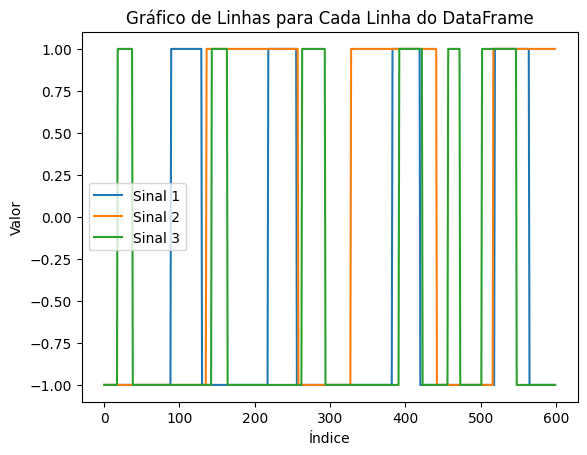

In [1817]:
labeled_df = rotular_df(normalized_df, "Onda Quadrada")
plot_line_for_each_row(labeled_df)


In [1818]:
def percorrer_janelas(labeled_df, tamanho_janela=100):
    if 'x' not in labeled_df.columns:
        raise ValueError("O DataFrame deve conter uma coluna 'x'")
    
    # Iterar sobre cada linha do DataFrame
    for index, row in labeled_df.iterrows():
        # Extrair os valores da coluna 'x' como uma lista (assumindo que os valores são strings concatenadas)
        lista_x = list(map(float, row['x'].split()))
        
        # Percorrer a lista de 'x' em janelas do tamanho configurável
        for i in range(0, len(lista_x), tamanho_janela):
            # Extrair a janela atual
            janela = lista_x[i:i + tamanho_janela]
            
            # Processar a janela (aqui você pode implementar a lógica desejada para cada janela)
            print(f"Linha {index + 1}, Janela {i // tamanho_janela + 1}: {janela}")
            
        print(f"Finalizada a lista da linha {index + 1}\n")

In [1819]:
#percorrer_janelas(labeled_df, tamanho_janela=50)

In [1820]:
def get_sequence(n_timesteps, data, label):
    sequences = []
    labels = []
    
    # Percorrer os dados e garantir que a sequência esteja completa
    for i in range(0, len(data) - n_timesteps + 1, n_timesteps):
        seq = data[i:i + n_timesteps]  # Obter a janela de dados
        
        # Verificar se a sequência tem o tamanho exato de n_timesteps
        if len(seq) == n_timesteps:
            sequences.append(seq)          # Adicionar a janela à lista de sequências
            labels.append(label)           # Adicionar o rótulo único para essa linha
    
    return np.array(sequences), np.array(labels)


In [1821]:
# Função para avaliar o modelo com base em dados reais
def evaluate_model(df_processed, y_real_pred):
    first_column = df_processed.iloc[:, 0]

    if len(y_real_pred) > len(first_column):
        y_real_pred = y_real_pred[:len(first_column)]
    elif len(y_real_pred) < len(first_column):
        first_column = first_column[:len(y_real_pred)]

    # Cálculo da acurácia
    accuracy_real = accuracy_score(first_column, y_real_pred)
    print(f"Accuracy for real data = {accuracy_real:.2f}")

    # Cálculo da matriz de confusão
    conf_matrix_real = confusion_matrix(first_column, y_real_pred)
    print("Confusion Matrix for real data:\n", conf_matrix_real)

    return accuracy_real, conf_matrix_real

In [1822]:
# Função para criar o modelo LSTM bidirecional
def get_bi_lstm_model(n_timesteps, mode):
    model = Sequential()
    model.add(Input(shape=(n_timesteps, 1)))
    model.add(Bidirectional(LSTM(20, return_sequences=False), merge_mode=mode))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [1823]:
def train_sequence_model(df):
    n_timesteps = 100  # Tamanho da janela
    num_iterations = 250
    model_filename = 'model.pkl'
    scaler_filename = 'scaler.pkl'

    # Dividir o DataFrame em conjunto de treino e teste
    df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)

    # Escalonamento dos dados
    scaler = StandardScaler()

    # Extrair os valores da coluna 'x', que são strings de valores concatenados
    df_train_sorted = df_train.sort_index().copy()
    df_test_sorted = df_test.sort_index().copy()

    # Extrair e processar os valores de 'x'
    train_sequences = []
    test_sequences = []
    train_labels = []
    test_labels = []

    # Processar os dados de treino
    for index, row in df_train_sorted.iterrows():
        x_values = list(map(float, row['x'].split()))  # Transformar string em lista de floats
        train_sequences.append(x_values)

        # Obter o rótulo para cada linha (por exemplo, uma coluna 'label' pode ser usada)
        label = row['label']  # Supomos que existe uma coluna 'label' com os rótulos corretos
        train_labels.append(label)

    # Processar os dados de teste
    for index, row in df_test_sorted.iterrows():
        x_values = list(map(float, row['x'].split()))  # Transformar string em lista de floats
        test_sequences.append(x_values)

        label = row['label']  # Supomos que existe uma coluna 'label' com os rótulos corretos
        test_labels.append(label)

    # Normalizar os valores de treino e teste
    train_sequences_flat = [item for sublist in train_sequences for item in sublist]
    test_sequences_flat = [item for sublist in test_sequences for item in sublist]

    train_sequences_flat = scaler.fit_transform(np.array(train_sequences_flat).reshape(-1, 1)).flatten()
    test_sequences_flat = scaler.transform(np.array(test_sequences_flat).reshape(-1, 1)).flatten()

    # Obter sequências de treino e teste
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    # Obter as sequências e rótulos para o conjunto de treino
    for i, seq in enumerate(train_sequences):
        X_seq, y_seq = get_sequence(n_timesteps, train_sequences_flat[i * len(seq):(i + 1) * len(seq)], train_labels[i])
        X_train.extend(X_seq)
        y_train.extend(y_seq)

    # Obter as sequências e rótulos para o conjunto de teste
    for i, seq in enumerate(test_sequences):
        X_seq, y_seq = get_sequence(n_timesteps, test_sequences_flat[i * len(seq):(i + 1) * len(seq)], test_labels[i])
        X_test.extend(X_seq)
        y_test.extend(y_seq)

    # Converter para numpy arrays e reshape para entrada do modelo
    X_train = np.array(X_train).reshape(-1, n_timesteps, 1)
    y_train = np.array(y_train).reshape(-1, 1)
    X_test = np.array(X_test).reshape(-1, n_timesteps, 1)
    y_test = np.array(y_test).reshape(-1, 1)

    # Treinar o modelo LSTM
    model = get_bi_lstm_model(n_timesteps, 'concat')

    start_time = timeit.default_timer()

    # Treinamento iterativo
    model.fit(X_train, y_train, epochs=num_iterations, batch_size=1, verbose=1)

    end_time = timeit.default_timer()

    # Fazer predições no conjunto de teste
    y_pred = model.predict(X_test)

    # Converter previsões contínuas para rótulos binários (0 ou 1) usando limiar de 0.5
    y_pred_labels = (y_pred > 0.5).astype(int).flatten()
    y_test_labels = (y_test > 0.5).astype(int).flatten()

    # Cálculo da acurácia e matriz de confusão para todas as previsões
    accuracy = accuracy_score(y_test_labels, y_pred_labels)
    conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

    print(f"Accuracy = {accuracy:.2f}, Time = {end_time - start_time:.4f} seconds")
    print("Confusion Matrix:\n", conf_matrix)


    return model


In [1824]:
# Salvar o modelo e o scaler

NameError: name 'save_model' is not defined

In [1831]:
import import_ipynb
import accelerationwaves

In [1832]:
model = train_sequence_model(accelerationwaves.labeled_df)

AttributeError: module 'accelerationwaves' has no attribute 'labeled_df'